In [1]:
pip install --ignore-installed --upgrade tensorflow

  Using cached tensorflow-2.16.2-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.16.2-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp311-cp311-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\USER\\anaconda3\\envs\\SND\\Lib\\site-packages\\numpy\\core\\_multiarray_tests.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade scikit-image

Note: you may need to restart the kernel to use updated packages.


# ML approach for neutrino selection

This notebook demonstrates an overview of the current status of the neural network study.

#### Importing packages (some of them are, in fact, not used)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc, shutil, time
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import skimage.transform
# from tqdm import tqdm

#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
# from cnn_utils import *

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Concatenate, Add
#from tensorflow.keras import optimizers, metrics, losses
import tensorflow.keras.optimizers, tensorflow.keras.metrics, tensorflow.keras.losses
from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.utils import HDF5Matrix, to_categorical

import tensorflow.keras.backend as K
from tensorflow.keras.utils import get_custom_objects
K.set_image_data_format('channels_last')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

#### Wall coordinates

Geometrical configurations for the wall selection and for the hit 2D visualisations (in matplotlib)

In [5]:
wall_coords = [0, 300.+1, 313.+1, 326.+1, 339.+1, 352.+3]
# event_map_w = event_map * (event_meta[:,0]>wall_coords[i_wall]) * (event_meta[:,0]<wall_coords[i_wall+1])

In [6]:
imextent = {
    'scifi_h':(0, 5, 15, 54),
    'scifi_v':(0, 5, -46, -7),
    'us_h':(0, 5, 12, 66),
    'us_v':(0, 5, 4, -79),
    'ds_h':(0, 4, 7, 71),
    'ds_v':(0, 4, 2, -79),
}

## Data formation

In [7]:
#path = '/mnt/ML-drive/Artem/SND/data/neutrino_ml/MC_explore/neutrino/sndlhc_13TeV_down_volTarget_100fb-1_SNDG18_02a_01_000/'
path='d:\\cern\\SND\\artem\\ndata\\'
### Loading data from .npy files into hdf5
# with h5py.File(path+'data.h5', 'a') as df:
#     for name in os.listdir(path):
#         if not name.endswith(".npy"): continue
#         data_tmp = np.load(path+name)
#         if data_tmp.ndim > 2:
#             data_tmp = np.transpose(data_tmp, axes=(0,2,3,1))
#         df.create_dataset(name[:-4], data=data_tmp)
with h5py.File(path+'data.h5', 'r') as df:
    for n in df.keys():
        if n=='ids' or n=='label': continue
        print(n, df[n].shape)

ds (83851, 4, 60, 2)
event_metadata (83851, 7)
scifi (83851, 5, 1536, 2)
us (83851, 5, 10, 2)


In [8]:
## KEYS OF METADATA
## event_meta[i_event] = (event.MCTrack[0].GetStartZ(), event.MCTrack[0].GetPdgCode(), event.MCTrack[1].GetPdgCode())
with h5py.File(path+'data.h5', 'r') as df:
    metadata = df['event_metadata'][...]
map_ve = (np.abs(metadata[:,1])==12) * (np.abs(metadata[:,2])!=12)
map_nc = (np.abs(metadata[:,1])==np.abs(metadata[:,2]))# * ((np.abs(metadata[:,1])!=12))
map_vm_cc = (np.abs(metadata[:,1])==14) * (np.abs(metadata[:,2])!=14)

In [9]:
print('ve:', np.sum(map_ve))
print('nc:', np.sum(map_nc))
print('vm_cc:', np.sum(map_vm_cc))

ve: 14757
nc: 20265
vm_cc: 47946


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
def which_wall(pos, wall_coords):
    for i in range(5):
        if (pos>wall_coords[i]) and (pos<wall_coords[i+1]):
            return i
    return -1

In [12]:
ids_ve = np.arange(metadata.shape[0])[map_ve]
ids_nc = np.arange(metadata.shape[0])[map_nc]
ids_vm_cc = np.arange(metadata.shape[0])[map_vm_cc]

#assigning zero to NC and vmcc events for neutrino energy
################
#metadata[ids_nc, 6]=0.0
#metadata[ids_vm_cc, 6]=0.0
###assunged zero end of block
#################################


all_ids = np.concatenate((ids_ve, ids_vm_cc, ids_nc))
#all_ids1=[all_ids,all_ids,all_ids]
all_labels=metadata[all_ids, 3]  #it is taken as x-axis already done
#all_labels=metadata[all_ids, 4]     #label 4 for y 
#all_labels=metadata[all_ids, 5]   #it is energy neutrino
#all_labels=metadata[all_ids, 6]    #lepton energy
#all_labels=np.subtract(metadata[all_ids, 5],metadata[all_ids, 6])   #hadron energy
#all_labels=metadata[all_ids, 0]    #z-axis 
#print('success   sss ',all_labels)
#all_labels = np.concatenate((np.ones_like(ids_ve)*0, np.ones_like(ids_vm_cc)*1, np.ones_like(ids_nc)*2))
all_walls = np.array([which_wall(metadata[id_ev, 0], wall_coords) for id_ev in all_ids])
if np.any(all_walls<0): print(all_ids[all_walls<0], '\n', metadata[all_ids[all_walls<0], 0], '\n', metadata[all_ids[all_walls<0], 1])
    

test_size = 0.2
tr_ids, test_ids, tr_lab, test_lab = train_test_split(all_ids, all_labels, test_size=test_size, shuffle=True)
#True was originoally
print('train:')
print(np.unique(tr_lab, return_counts=True))
print('test:')
#print(np.unique(test_lab, return_counts=True))
list(tr_ids)
# with h5py.File(path+'data.h5', 'a') as df:
#     df.create_dataset('ids/train', data=tr_ids)
#     df.create_dataset('ids/test', data=test_ids)
#     df.create_dataset('label/train', data=tr_lab)
#     df.create_dataset('label/test', data=test_lab)
'''
with h5py.File(path+'data.h5', 'r') as df:
    tr_ids = df['ids/train'][...]
    test_ids = df['ids/test'][...]
    tr_lab = df['label/train'][...]
    test_lab = df['label/test'][...]
'''    

train:
(array([-47.86852264, -47.82230377, -47.82129288, ...,  -5.47550869,
        -5.45646954,  -5.43662024]), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))
test:


"\nwith h5py.File(path+'data.h5', 'r') as df:\n    tr_ids = df['ids/train'][...]\n    test_ids = df['ids/test'][...]\n    tr_lab = df['label/train'][...]\n    test_lab = df['label/test'][...]\n"

In [13]:
tr_sort = np.argsort(tr_ids)
tr_ids = tr_ids[tr_sort].astype(int)
tr_lab = tr_lab[tr_sort]
tr_walls = np.array([which_wall(metadata[id_ev, 0], wall_coords) for id_ev in tr_ids])
if np.any(tr_walls<0):
    print(tr_ids[tr_walls<0], '\n', metadata[tr_ids[tr_walls<0], 0], '\n', metadata[tr_ids[tr_walls<0], 1])
    raise ValueError("event outside scifi walls")

test_sort = np.argsort(test_ids)
test_ids = test_ids[test_sort].astype(int)
test_lab = test_lab[test_sort]
test_walls = np.array([which_wall(metadata[id_ev, 0], wall_coords) for id_ev in test_ids])
if np.any(test_walls<0): 
    print(test_ids[test_walls<0], '\n', metadata[test_ids[test_walls<0], 0], '\n', metadata[test_ids[test_walls<0], 1])
    raise ValueError("event outside scifi walls")

In [14]:
det_names = ['scifi', 'us', 'ds']
x_tr = {}
x_test = {}
with h5py.File(path+'data.h5', 'r') as df:
    for name in det_names:
        tmp_data = df[name][...]
        print(name, tmp_data[tr_ids].shape)
        if name=='scifi':
            x_tr['scifi_h'] = (tmp_data[tr_ids, :, :, 0].copy())[..., np.newaxis]
            x_tr['scifi_v'] = (tmp_data[tr_ids, :, :, 1].copy())[..., np.newaxis]
            print('tr scifi_h: ', x_tr['scifi_h'].shape)
            print('tr scifi_v: ', x_tr['scifi_v'].shape)
            x_test['scifi_h'] = (tmp_data[test_ids, :, :, 0].copy())[..., np.newaxis]
            x_test['scifi_v'] = (tmp_data[test_ids, :, :, 1].copy())[..., np.newaxis]
            print('tr scifi_h: ', x_test['scifi_h'].shape)
            print('tr scifi_v: ', x_test['scifi_v'].shape)
            # x_test[name] = tmp_data[test_ids].copy()
            # print('test '+name+': ', x_test[name].shape)
        else:
            x_tr[name] = tmp_data[tr_ids].copy()
            print('tr '+name+': ', x_tr[name].shape)
            x_test[name] = tmp_data[test_ids].copy()
            print('test '+name+': ', x_test[name].shape)
gc.collect();

scifi (66374, 5, 1536, 2)
tr scifi_h:  (66374, 5, 1536, 1)
tr scifi_v:  (66374, 5, 1536, 1)
tr scifi_h:  (16594, 5, 1536, 1)
tr scifi_v:  (16594, 5, 1536, 1)
us (66374, 5, 10, 2)
tr us:  (66374, 5, 10, 2)
test us:  (16594, 5, 10, 2)
ds (66374, 4, 60, 2)
tr ds:  (66374, 4, 60, 2)
test ds:  (16594, 4, 60, 2)


In [15]:
print(tr_lab)

[-14.34622288 -29.9801693  -20.14690208 ... -25.30768585  -9.00961781
 -23.01368332]


## Toy model definition

### Full model

In [16]:
n_cl = 3
n_wall = 5
scifi_shape=(5,1536,1)
us_shape=(5,10,2)
ds_shape=(4,60,2)
drop_middle_scifi = 0.5
drop_middle_us = 0.5
drop_middle_ds = 0.5

lr=2e-4 #; betaa1=30; betaa2=100; decay=1e-3

### SciFi
scifi_h_input = Input(scifi_shape, name='scifi_h_in')
X_scifi_h = Conv2D(16, kernel_size=(3,4), padding='same', activation='elu', name='scifi_h_conv1_1')(scifi_h_input)
X_scifi_h = Conv2D(16, kernel_size=(3,4), padding='same', activation='elu', name='scifi_h_conv1_2')(X_scifi_h)
X_scifi_h = MaxPooling2D(pool_size=(1,4), padding='valid', name='scifi_h_pool1')(X_scifi_h)

X_scifi_h = Conv2D(32, kernel_size=(3,4), padding='same', activation='elu', name='scifi_h_conv2_1')(X_scifi_h)
X_scifi_h = MaxPooling2D(pool_size=(1,4), padding='valid', name='scifi_h_pool2')(X_scifi_h)

X_scifi_h = Dropout(rate=drop_middle_scifi, name='scifi_h_drop_middle')(X_scifi_h)

X_scifi_h = Conv2D(32, kernel_size=(3,4), padding='same', activation='elu', name='scifi_h_conv3_1')(X_scifi_h)
X_scifi_h = MaxPooling2D(pool_size=(1,2), padding='valid', name='scifi_h_pool3')(X_scifi_h)

X_scifi_h = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='scifi_h_conv4_1')(X_scifi_h)
X_scifi_h = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='scifi_h_conv4_2')(X_scifi_h)
X_scifi_h = MaxPooling2D(pool_size=(2,2), padding='same', name='scifi_h_pool4')(X_scifi_h)
X_scifi_h = Flatten()(X_scifi_h)

### SciFi
scifi_v_input = Input(scifi_shape, name='scifi_v_in')
X_scifi_v = Conv2D(16, kernel_size=(3,4), padding='same', activation='elu', name='scifi_v_conv1_1')(scifi_v_input)
X_scifi_v = Conv2D(16, kernel_size=(3,4), padding='same', activation='elu', name='scifi_v_conv1_2')(X_scifi_v)
X_scifi_v = MaxPooling2D(pool_size=(1,4), padding='valid', name='scifi_v_pool1')(X_scifi_v)

X_scifi_v = Conv2D(32, kernel_size=(3,4), padding='same', activation='elu', name='scifi_v_conv2_1')(X_scifi_v)
X_scifi_v = MaxPooling2D(pool_size=(1,4), padding='valid', name='scifi_v_pool2')(X_scifi_v)

X_scifi_v = Dropout(rate=drop_middle_scifi, name='scifi_v_drop_middle')(X_scifi_v)

X_scifi_v = Conv2D(32, kernel_size=(3,4), padding='same', activation='elu', name='scifi_v_conv3_1')(X_scifi_v)
X_scifi_v = MaxPooling2D(pool_size=(1,2), padding='valid', name='scifi_v_pool3')(X_scifi_v)

X_scifi_v = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='scifi_v_conv4_1')(X_scifi_v)
X_scifi_v = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='scifi_v_conv4_2')(X_scifi_v)
X_scifi_v = MaxPooling2D(pool_size=(2,2), padding='same', name='scifi_v_pool4')(X_scifi_v)
X_scifi_v = Flatten()(X_scifi_v)


### US
us_input = Input(us_shape, name='us_in')
X_us = Conv2D(16, kernel_size=(3,3), padding='same', activation='elu', name='us_conv1_1')(us_input)
X_us = Conv2D(32, kernel_size=(3,3), padding='same', activation='elu', name='us_conv1_2')(X_us)
X_us = MaxPooling2D(pool_size=2, padding='same', name='us_pool1')(X_us)

X_us = Conv2D(32, kernel_size=(3,3), padding='same', activation='elu', name='us_conv2_1')(X_us)
X_us = MaxPooling2D(pool_size=2, padding='same', name='us_pool2')(X_us)

X_us = Dropout(rate=drop_middle_us, name='us_drop_middle')(X_us)

X_us = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='us_conv3_1')(X_us)
X_us = Flatten()(X_us)

### DS
ds_input = Input(ds_shape, name='ds_in')
X_ds = Conv2D(16, kernel_size=(3,3), padding='same', activation='elu', name='ds_conv1_1')(ds_input)
X_ds = Conv2D(32, kernel_size=(3,3), padding='same', activation='elu', name='ds_conv1_2')(X_ds)
X_ds = MaxPooling2D(pool_size=(1,2), padding='same', name='ds_pool1')(X_ds)

X_ds = Conv2D(32, kernel_size=(3,3), padding='same', activation='elu', name='ds_conv2_1')(X_ds)
X_ds = MaxPooling2D(pool_size=2, padding='same', name='ds_pool2')(X_ds)

X_ds = Dropout(rate=drop_middle_ds, name='ds_drop_middle')(X_ds)

X_ds = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='ds_conv3_1')(X_ds)
X_ds = Flatten()(X_ds)



X = Concatenate()([X_scifi_h, X_scifi_v, X_us, X_ds])
#X_cl = Dense(n_cl, activation='softmax', name='y_class')(X)
X_cl = Dense(1)(X)
#X_wall = Dense(n_wall, activation='softmax', name='y_wall')(X)

toy_model = Model(inputs = [scifi_h_input, scifi_v_input, us_input, ds_input], outputs = X_cl, name='full_toy_model')

K.clear_session()

adamka = tf.keras.optimizers.Adam(learning_rate=lr)
toy_model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
#toy_model.compile(optimizer=adamka, loss={'y_class':'categorical_crossentropy', 'y_wall':'categorical_crossentropy'}, metrics={'y_class':'categorical_accuracy', 'y_wall':'categorical_accuracy'})

In [17]:
#toy_model.summary()
#validation_data=validation_generator
#vdata=[x_tr['scifi_h'], x_tr['scifi_v'], x_tr['us'], x_tr['ds']]
#hist = toy_model.fit(x=[x_tr['scifi_h'], x_tr['scifi_v'], x_tr['us'], x_tr['ds']], y=tr_lab, batch_size=128, epochs=100, validation_data= )

In [18]:
#hist = toy_model.fit(x=[x_tr['scifi_h'], x_tr['scifi_v'], x_tr['us'], x_tr['ds']], y=tr_lab, batch_size=128, epochs=30)

In [19]:
retoy_model = tf.keras.models.load_model(path+"toy_neutrino_25")    

In [20]:
#toy_model.save(path+'toy_neutrino_nczerolep')

In [21]:
'''
history_df = pd.DataFrame(hist.history)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
#plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['mae'])
#plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('mean absolute error: MAE')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend();
'''

"\nhistory_df = pd.DataFrame(hist.history)\nplt.figure(figsize=(12,4))\nplt.subplot(1,2,1)\nplt.plot(history_df['loss'], label='training loss')\n#plt.plot(history_df['val_loss'], label='validation loss')\nplt.title('Model Loss Function')\nplt.xlabel('Epochs')\nplt.ylabel('Loss Function')\nplt.legend()\nplt.subplot(1,2,2)\nplt.plot(history_df['mae'])\n#plt.plot(history_df['val_accuracy'], label='validation accuracy')\nplt.title('mean absolute error: MAE')\nplt.xlabel('Epochs')\nplt.ylabel('Error')\nplt.legend();\n"

## Train model

In [22]:
#test=retoy_model.predict(x=[x_test['scifi_h'], x_test['scifi_v'], x_test['us'], x_test['ds']])
test=retoy_model.predict(x=[x_test['scifi_h'], x_test['scifi_v'], x_test['us'], x_test['ds']])

519/519 [==============================] - 41s 77ms/step


In [23]:
#np.savetxt(path+'/xyz/'+'x.csv',test,test_lab,test_ids,ids_ve,ids_vm_cc,ids_nc)
'''
np.savetxt(path+'/xyz/'+'xtest.csv',test)
np.savetxt(path+'/xyz/'+'xtest_lab.csv',test_lab)
np.savetxt(path+'/xyz/'+'xtest_ids.csv',test_ids)
np.savetxt(path+'/xyz/'+'xids_ve.csv',ids_ve)
np.savetxt(path+'/xyz/'+'xids_vm_cc.csv',ids_vm_cc)
np.savetxt(path+'/xyz/'+'xids_nc.csv',ids_nc)
'''

"\nnp.savetxt(path+'/xyz/'+'xtest.csv',test)\nnp.savetxt(path+'/xyz/'+'xtest_lab.csv',test_lab)\nnp.savetxt(path+'/xyz/'+'xtest_ids.csv',test_ids)\nnp.savetxt(path+'/xyz/'+'xids_ve.csv',ids_ve)\nnp.savetxt(path+'/xyz/'+'xids_vm_cc.csv',ids_vm_cc)\nnp.savetxt(path+'/xyz/'+'xids_nc.csv',ids_nc)\n"

In [24]:
#print(test_la[test_ids])

In [25]:
x_ax = range(len(test))
x_labb = range(len(test_lab))
print(x_ax,x_labb)
print(test[16593],test_lab[16593])

range(0, 16594) range(0, 16594)
[-25.336134] -21.141990661621094


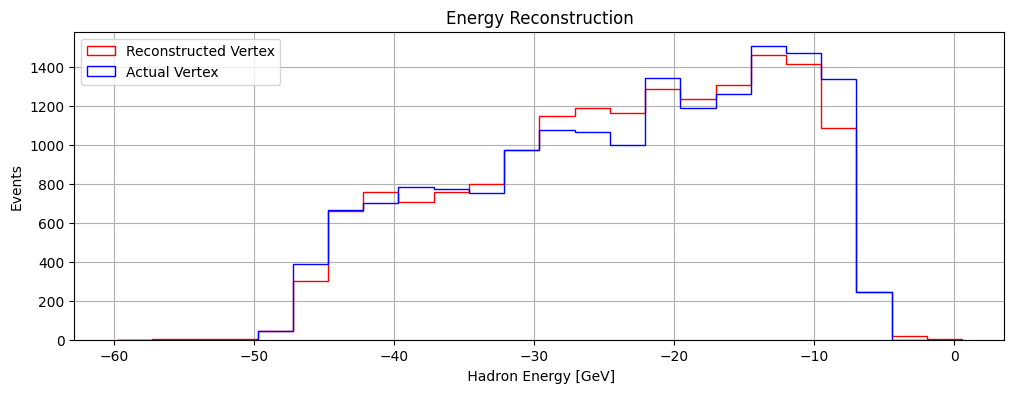

In [26]:
#plt.close('all')
string='y-Coordinate [cm]'
string=' Hadron Energy [GeV]'
#binsize=0.1
#ddd=np.divide((max(test) - min(test)),binsize)
#print(ddd)
#ddd=range(typeof(Decimal),min(test), max(test
string_title='Vortex Reconstruction y-Component'
string_title='Energy Reconstruction'
plt.figure(figsize=(12,4))
#plt.subplot(1,2,1)
#ubin=np.linspace(min(test),max(test), 25)
#print(ubin)
xyz=plt.hist(test, bins=np.linspace(np.min(test), np.max(test), num=25),histtype='step', color='red',density=False, linestyle='solid',label='Reconstructed Vertex' )
plt.xlabel(string)
plt.ylabel("Events")
plt.hist(test_lab, bins=np.linspace(np.min(test), np.max(test), num=25),linestyle='solid', histtype='step', color='blue',density=False,label='Actual Vertex')
plt.xlabel(string)
plt.ylabel("Events")
plt.title(string_title)
plt.legend()
plt.grid()
#plt.xlim([270, 360])
#print(xyz[1])

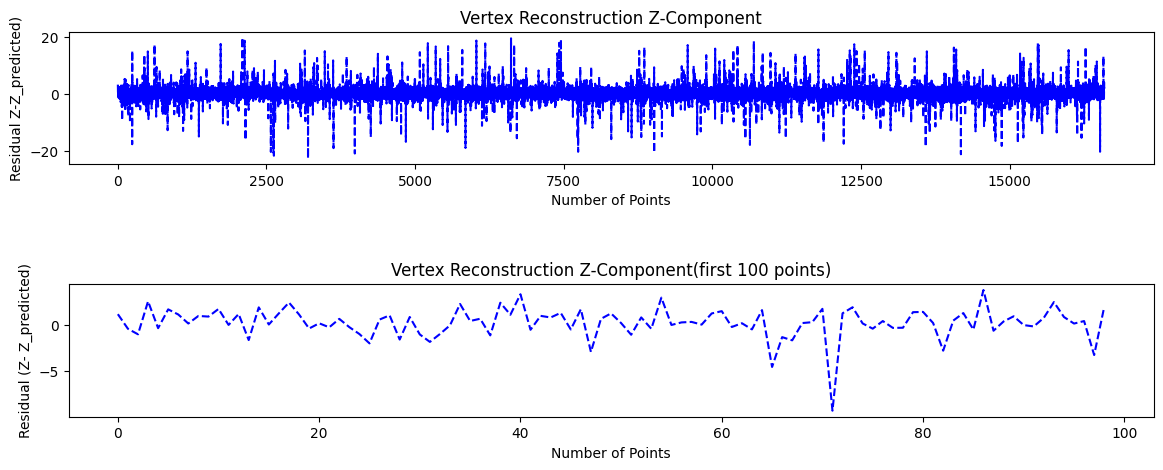

In [27]:
#vec_pred=np.array(test)
#vec_act=np.array(test_lab) 
 
#print(residual[4])

def  resid(test,test_lab,flag):
     residual=[] 
     residual_rel=[]
     for i in range(0,len(test)):
         #print(i)
         #AAA=np.absolute(test[i])
         midd=np.subtract(test_lab[i],test[i])
         midd1=np.divide(midd,test_lab[i])
         #midd=np.divide(midd,test_lab[i])
         residual_rel.append(midd1)
         residual.append(midd)
     if flag == 1:       
        return residual
     else:
        return residual_rel
    
residual=resid(test,test_lab,1)
residual_rel=resid(test,test_lab,2)
#print('ffff',max(residual))
#print(len(test))
test_sort = np.argsort(test).astype(float)
#vec_diff=np.subtract(vec_act[0:10],vec_pred[0:10])
plt.figure(figsize=(14,5))
plt.subplots_adjust(hspace=0.9)
plt.subplot(2,1,1)
plt.plot(residual, 'b--', label="actual")
#plt.plot(test_lab [0:100], lw=0.8, color="red",linestyle=None, marker=".",label="predicted")
plt.xlabel("Number of Points")
plt.ylabel("Residual Z-Z_predicted)")
plt.title('Vertex Reconstruction Z-Component')
#plt.legend()
plt.subplot(2,1,2)
plt.plot(residual[1:100], 'b--',label="actual")
#plt.plot(test_lab [0:100], lw=0.8, color="red",linestyle=None, marker=".",label="predicted")

plt.xlabel("Number of Points")
plt.ylabel("Residual (Z- Z_predicted)")
plt.title('Vertex Reconstruction Z-Component(first 100 points)')
#plt.legend()

plt.show()


 

Text(0.5, 1.0, 'Residual Energy Reconstruction')

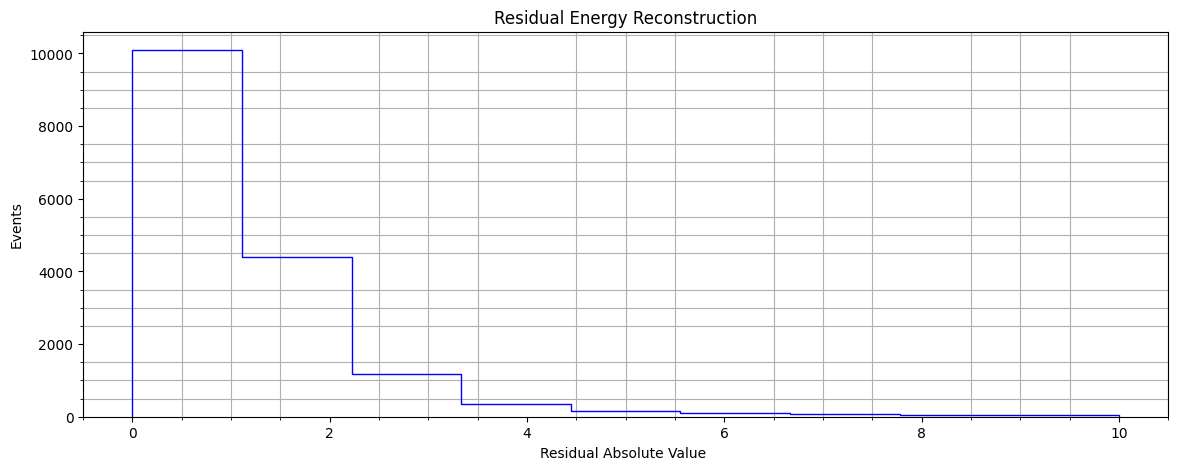

In [28]:

abss=np.absolute(residual)
plt.figure(figsize=(14,5))
#plt.hist(residual, bins=200)
#nbin=np.linspace(np.min(test), np.max(test), num=25)
nbin=np.linspace(0,10, num=10)
ssss=plt.hist(abss, bins=nbin,linestyle='solid', color='blue',histtype='step',density=False,label='Actual Vertex')
plt.xlabel("Residual Absolute Value ")
plt.ylabel("Events")
plt.minorticks_on()
plt.grid(which = "minor")
plt.title('Residual ' + string_title)

In [29]:
#print (ssss[0]) 
#print(ssss[0][19])
# Adjust the bar widths here 
#plt.hist(values, rwidth=0.9) 
#print(len(ssss[0]),len(ssss[1]))



In [30]:
def addlabels(x,y):
    count=0
    total=0
    for i in range(len(x)):        
        #plt.text(i,y[i],y[i])
        percent=np.divide(y[i],len(test))
        
        txt=round(percent*100)
        total=total+txt
        anot = str(txt)+'%'
        anot=str(y[i]) +'  (' + anot +')'
        plt.text(i,y[i]+100,anot,color='green')
        count=count+1
        if count > 5:
           plt.text(i+2,y[i],'<'+ str(100-total) +'%', color='red')  
           break

9 9


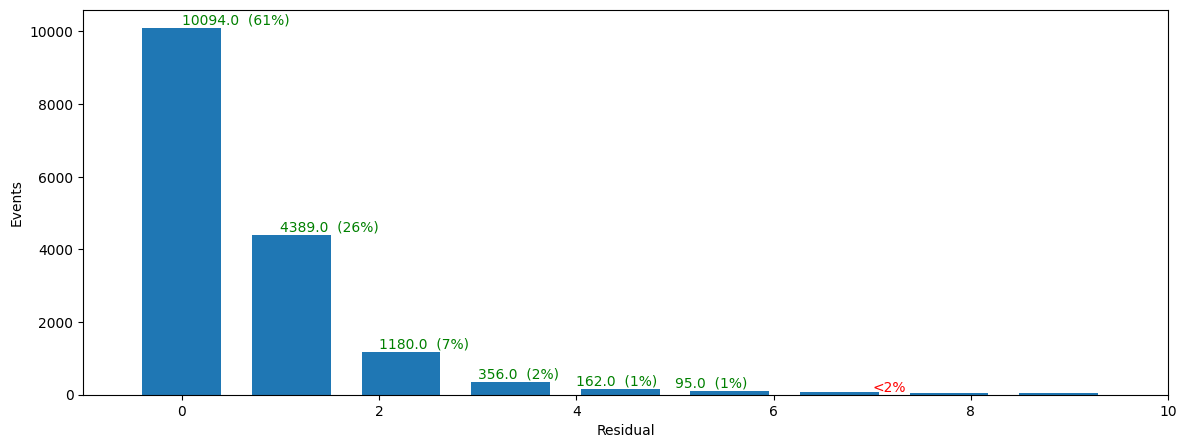

In [31]:
x_temp= []
y_temp=[]
x_temp= ssss[1].copy()
y_temp= ssss[0].copy()
lnx=len(x_temp)
lny=len(y_temp)
x_temp=np.delete(x_temp,lnx-1)
print(len(y_temp),len(x_temp))
plt.figure(figsize=(14,5))
plt.bar(x_temp,y_temp)
#plt.xticks(x_temp)
plt.xlabel('Residual')
plt.ylabel('Events')
plt.xlim([-1,10])
addlabels(x_temp, y_temp)

In [32]:
print(len(test))

16594


In [33]:
percent=np.divide(y_temp[0],len(test))
print(percent*100,y_temp[0],len(test))

60.82921537905267 10094.0 16594


In [34]:
'''
abss=np.absolute(residual)

#abss=residual
plt.figure(figsize=(14,5))
#plt.hist(residual, bins=200)
#nbin=np.linspace(np.min(test), np.max(test), num=25)
nbin=50
nbin=np.linspace(0,10, num=10)
ssss=plt.hist(abss, bins=nbin,linestyle='solid',histtype='step',density=False,label='Actual Vertex')
plt.xlabel("Residual Absolute Value ")
plt.ylabel("Events")
plt.minorticks_on()
plt.grid(which = "minor")
plt.title('Residual ' + string_title) 
'''

'\nabss=np.absolute(residual)\n\n#abss=residual\nplt.figure(figsize=(14,5))\n#plt.hist(residual, bins=200)\n#nbin=np.linspace(np.min(test), np.max(test), num=25)\nnbin=50\nnbin=np.linspace(0,10, num=10)\nssss=plt.hist(abss, bins=nbin,linestyle=\'solid\',histtype=\'step\',density=False,label=\'Actual Vertex\')\nplt.xlabel("Residual Absolute Value ")\nplt.ylabel("Events")\nplt.minorticks_on()\nplt.grid(which = "minor")\nplt.title(\'Residual \' + string_title) \n'

In [35]:
'''
import seaborn as sns
asss=residual
# matplotlib histogram
plt.hist(asss, edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(asss, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')
'''

"\nimport seaborn as sns\nasss=residual\n# matplotlib histogram\nplt.hist(asss, edgecolor = 'black',\n         bins = int(180/5))\n\n# seaborn histogram\nsns.distplot(asss, hist=True, kde=False, \n             bins=int(180/5), color = 'blue',\n             hist_kws={'edgecolor':'black'})\n# Add labels\nplt.title('Histogram of Arrival Delays')\nplt.xlabel('Delay (min)')\nplt.ylabel('Flights')\n"

In [36]:
'''
import numpy as np
import matplotlib.pyplot as plt
x=np.linspace(-10,10, num=10)
#x = np.arange(10)
y = np.arange(10) * 0.1
 
mask1 = x < 0
mask2 = x >0
print(mask1,'fffff',mask2)
print(x[mask1],'jjjjjj',x[mask2])
plt.bar(x[mask1], y[mask1], color = 'red')
plt.bar(x[mask2], y[mask2], color = 'blue')
plt.show()
'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\nx=np.linspace(-10,10, num=10)\n#x = np.arange(10)\ny = np.arange(10) * 0.1\n \nmask1 = x < 0\nmask2 = x >0\nprint(mask1,'fffff',mask2)\nprint(x[mask1],'jjjjjj',x[mask2])\nplt.bar(x[mask1], y[mask1], color = 'red')\nplt.bar(x[mask2], y[mask2], color = 'blue')\nplt.show()\n"

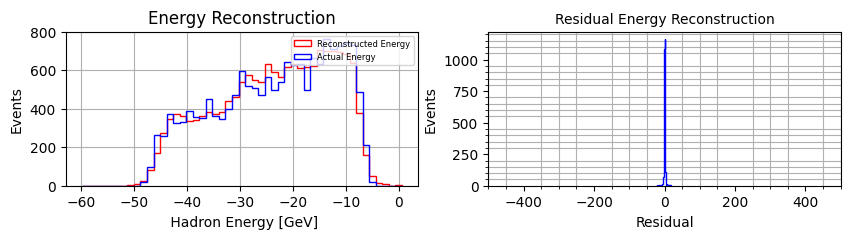

'\nplt.subplot(1,3,3)\nplt.hist(data_rel, bins=200,linestyle=\'solid\', color=\'blue\',histtype=\'step\',density=False,label=\'Actual Energy\')\n# Adding labels and title\nplt.xlabel(\'Relative Error\')\n\nplt.ylabel(\'Events\')\nplt.title(\'Residual \' + string_title) \n\nplt.xlim([-0.2,0.2])\nplt.minorticks_on()\nplt.grid(which = "minor")\n\n# Display the plot\nplt.show()\n'

In [37]:
import matplotlib.pyplot as plt
import numpy as np
SIZE=10
# Generate random data for the histogram
#data = np.random.randn(1000)
#data=residual.copy()
data=np.array(residual)
data_rel=np.array(residual_rel)
# Plotting a basic histogram
#plt.hist(data, bins=50, color='blue', edgecolor='black')
plt.figure(figsize=(10,2.0))
plt.subplot(1,2,1)
plt.hist(test, bins=np.linspace(np.min(test), np.max(test), num=50),histtype='step', color='red',density=False, linestyle='solid',label='Reconstructed Energy' )
plt.xlabel(string,fontsize=SIZE)

plt.ylabel("Events",fontsize=SIZE)
plt.hist(test_lab, bins=np.linspace(np.min(test), np.max(test), num=50),linestyle='solid', histtype='step', color='blue',density=False,label='Actual Energy')

plt.xlabel(string,fontsize=SIZE)
plt.ylabel("Events",fontsize=SIZE)
plt.title(string_title)
plt.legend(loc="upper right", fontsize=6)
plt.grid()
plt.subplot(1,2,2)
plt.hist(data, bins=200,linestyle='solid', color='blue',histtype='step',density=False,label='Actual Energy')
# Adding labels and title
plt.xlabel('Residual',fontsize=SIZE)

plt.ylabel('Events',fontsize=SIZE)
plt.title('Residual ' + string_title,fontsize=SIZE) 

plt.xlim([-500,500])
plt.minorticks_on()
plt.grid(which = "minor")
plt.show()
'''
plt.subplot(1,3,3)
plt.hist(data_rel, bins=200,linestyle='solid', color='blue',histtype='step',density=False,label='Actual Energy')
# Adding labels and title
plt.xlabel('Relative Error')

plt.ylabel('Events')
plt.title('Residual ' + string_title) 

plt.xlim([-0.2,0.2])
plt.minorticks_on()
plt.grid(which = "minor")

# Display the plot
plt.show()
'''

In [38]:
#all_ids = np.concatenate((ids_ve, ids_vm_cc, ids_nc))
#test_lb
#test_sort = np.argsort(test_ids)
#test_ids = test_ids[test_sort].astype(int)
#test_lab = test_lab[test_sort]
#print(len(test_ids),test_ids[16593])

#print(len(test_lab),test_lab[16593])

In [39]:
 
#c= np.intersect1d(b,a)
#print(xy,a_ind,b_ind)
 

In [40]:
xy, ve_ind, b_ind= np.intersect1d(test_ids, ids_ve, return_indices=True)
xy, vm_ind, b_ind= np.intersect1d(test_ids, ids_vm_cc, return_indices=True)
xy, nc_ind, b_ind= np.intersect1d(test_ids, ids_nc, return_indices=True)
ve_vertex_o=test_lab[ve_ind]
vm_vertex_o=test_lab[vm_ind]
nc_vertex_o=test_lab[nc_ind]

ve_vertex_t=test[ve_ind]
vm_vertex_t=test[vm_ind]
nc_vertex_t=test[nc_ind]

re_ve=resiudal=resid(ve_vertex_t,ve_vertex_o,1)
re_vm=resiudal=resid(vm_vertex_t,vm_vertex_o,1)
re_nc=resiudal=resid(nc_vertex_t,nc_vertex_o,1)
re_ve=np.array(re_ve)
re_vm=np.array(re_vm)
re_nc=np.array(re_nc)
 

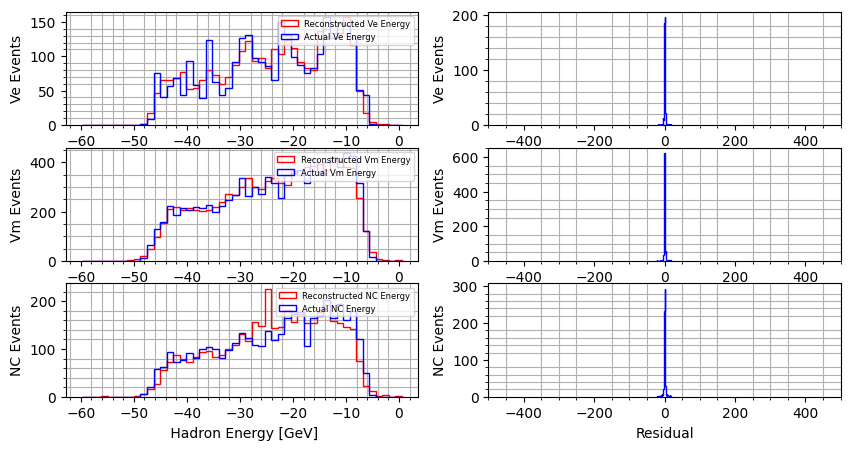

In [41]:
plt.figure(figsize=(10,5))
SIZE=10
plt.subplot(3,2,1)
plt.hist(ve_vertex_t, bins=np.linspace(np.min(vm_vertex_t), np.max(vm_vertex_t), num=50),histtype='step', color='red',density=False, linestyle='solid',label='Reconstructed Ve Energy' )
plt.xlabel(string,fontsize=SIZE)
plt.ylabel("Ve Events",fontsize=SIZE)
 
plt.hist(ve_vertex_o, bins=np.linspace(np.min(vm_vertex_t), np.max(vm_vertex_t), num=50),linestyle='solid', histtype='step', color='blue',density=False,label='Actual Ve Energy')
plt.minorticks_on()
plt.grid(which = "minor")
plt.legend(loc="upper right", fontsize=6)
plt.subplot(3,2,2)
plt.hist(re_ve, bins=200,linestyle='solid', color='blue',histtype='step',density=False,label='Actual Vertex')
# Adding labels and title
plt.xlabel('Residual',fontsize=SIZE)

plt.ylabel('Ve Events',fontsize=SIZE)
#plt.title('Residual ' + string_title) 

plt.xlim([-500,500])
plt.minorticks_on()
plt.grid(which = "minor")

############Vm###############
 
plt.subplot(3,2,3)
plt.hist(vm_vertex_t, bins=np.linspace(np.min(vm_vertex_t), np.max(vm_vertex_t), num=50),histtype='step', color='red',density=False, linestyle='solid',label='Reconstructed Vm Energy' )
plt.xlabel(string,fontsize=SIZE)
plt.ylabel("Vm Events",fontsize=SIZE)
plt.hist(vm_vertex_o, bins=np.linspace(np.min(vm_vertex_t), np.max(vm_vertex_t), num=50),linestyle='solid', histtype='step', color='blue',density=False,label='Actual Vm Energy')
plt.minorticks_on()
plt.grid(which = "minor")
plt.legend(loc="upper right", fontsize=6)
plt.subplot(3,2,4)
plt.hist(re_vm, bins=200,linestyle='solid', color='blue',histtype='step',density=False,label='Actual Vertex')
# Adding labels and title
plt.xlabel('Residual',fontsize=SIZE)

plt.ylabel('Vm Events',fontsize=SIZE)
#plt.title('Residual ' + string_title,fontsize=20) 

plt.xlim([-500,500])
plt.minorticks_on()
plt.grid(which = "minor")
 
#####################znc########################
#plt.figure(figsize=(14,5))
plt.subplot(3,2,5)
plt.hist(nc_vertex_t, bins=np.linspace(np.min(vm_vertex_t), np.max(vm_vertex_t), num=50),histtype='step', color='red',density=False, linestyle='solid',label='Reconstructed NC Energy' )
plt.xlabel(string,fontsize=SIZE)
plt.ylabel("NC Events",fontsize=SIZE)
plt.hist(nc_vertex_o, bins=np.linspace(np.min(vm_vertex_t), np.max(vm_vertex_t), num=50),linestyle='solid', histtype='step', color='blue',density=False,label='Actual NC Energy')
plt.minorticks_on()
plt.grid(which = "minor")
plt.legend(loc="upper right", fontsize=6)
plt.subplot(3,2,6)
plt.hist(re_nc, bins=200,linestyle='solid', color='blue',histtype='step',density=False,label='Actual Vertex')
# Adding labels and title
plt.xlabel('Residual',fontsize=SIZE)

plt.ylabel('NC Events',fontsize=SIZE)
#plt.title('Residual ' + string_title) 

plt.xlim([-500,500])
plt.minorticks_on()
plt.grid(which = "minor")
 



In [42]:
#portion of a plot how to use
# carr = arr[(arr > 3) & (arr < 7)]
'''
test_labn=test_lab[(test_lab>25.0) & (test_lab <35.0)]
xy, a_ind, b_ind= np.intersect1d(test_lab, test_labn, return_indices=True)
#ttest_lab=test_lab[(test_lab>25.0) & (test_lab <35.0)]
#print(test_labn,a_ind)
#print(len(ttest_lab),len(ttest))
#tresidual=resid(ttest,ttest_lab,1)
testn=test[a_ind]
residual1=resid(testn,test_labn,1)
residual1=np.array(residual1)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(testn, bins=np.linspace(np.min(testn), np.max(testn), num=50),histtype='step', color='red',density=False, linestyle='solid',label='Reconstructed Ve Vertex' )
plt.xlabel(string,fontsize=SIZE)
plt.ylabel("Events",fontsize=SIZE)
plt.hist(test_labn, bins=np.linspace(np.min(testn), np.max(testn), num=50),linestyle='solid', histtype='step', color='blue',density=False,label='Actual Vertex')
plt.minorticks_on()
plt.grid(which = "minor")
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.hist(residual1, bins=50,histtype='step', color='blue',density=False, linestyle='solid',label='Reconstructed Vertex' )
plt.xlabel(residual,fontsize=SIZE)
plt.ylabel("Events",fontsize=SIZE)
plt.minorticks_on()

plt.grid(which = "minor")
plt.grid()
'''

'\ntest_labn=test_lab[(test_lab>25.0) & (test_lab <35.0)]\nxy, a_ind, b_ind= np.intersect1d(test_lab, test_labn, return_indices=True)\n#ttest_lab=test_lab[(test_lab>25.0) & (test_lab <35.0)]\n#print(test_labn,a_ind)\n#print(len(ttest_lab),len(ttest))\n#tresidual=resid(ttest,ttest_lab,1)\ntestn=test[a_ind]\nresidual1=resid(testn,test_labn,1)\nresidual1=np.array(residual1)\nplt.figure(figsize=(14,5))\nplt.subplot(1,2,1)\nplt.hist(testn, bins=np.linspace(np.min(testn), np.max(testn), num=50),histtype=\'step\', color=\'red\',density=False, linestyle=\'solid\',label=\'Reconstructed Ve Vertex\' )\nplt.xlabel(string,fontsize=SIZE)\nplt.ylabel("Events",fontsize=SIZE)\nplt.hist(test_labn, bins=np.linspace(np.min(testn), np.max(testn), num=50),linestyle=\'solid\', histtype=\'step\', color=\'blue\',density=False,label=\'Actual Vertex\')\nplt.minorticks_on()\nplt.grid(which = "minor")\nplt.grid()\nplt.legend()\nplt.subplot(1,2,2)\nplt.hist(residual1, bins=50,histtype=\'step\', color=\'blue\',densi

In [43]:
#a=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
#b=np.array([83,20,19,12,112,33,4,55,666,66,19])
#xy, a_ind, b_ind= np.intersect1d(a, b, return_indices=True)
#t=b[(b>15.0) & (b <35.0)]
#print(t)

In [44]:
#np.savetxt(path+'ve_energy_hed_t.csv',ve_vertex_t)
#np.savetxt(path+'ve_energy_hed_o.csv',ve_vertex_o)

In [45]:
VELEPT=np.loadtxt(path+'ve_energy_lep_t.csv')
VELEPO=np.loadtxt(path+'ve_energy_lep_o.csv')
VEHET=np.loadtxt(path+'ve_energy_hed_t.csv')
VEHEO=np.loadtxt(path+'ve_energy_hed_o.csv')

In [46]:
addve=np.add(VELEPT[0:2871],VEHET[0:2871])
addveo=np.add(VELEPO[0:2871],VEHEO[0:2871])


In [65]:
Re_ve=resid(addve,addveo,2)
Re_ve1=np.array(Re_ve)


Text(0, 0.5, 'Nue Events')

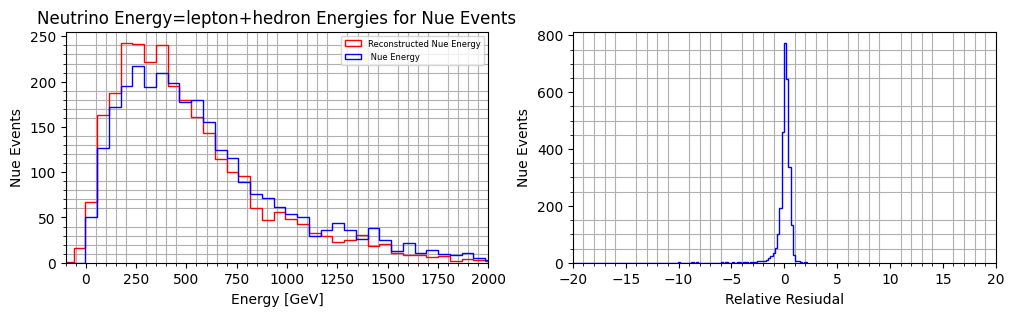

In [72]:
plt.figure(figsize=(12,3.0))
SIZE=10
plt.subplot(1,2,1)
#plt.hist(addve, bins=np.linspace(np.min(Re_ve), np.max(Re_ve), num=50),histtype='step', color='red',density=False, linestyle='solid',label='Reconstructed Nue Energy' )
#plt.hist(addveo, bins=np.linspace(np.min(Re_ve), np.max(Re_ve), num=50),histtype='step', color='blue',density=False, linestyle='solid',label=' Nue Energy' )
plt.hist(addve, bins=np.linspace(np.min(addve), np.max(addve), num=50),histtype='step', color='red',density=False, linestyle='solid',label='Reconstructed Nue Energy' )
plt.hist(addveo, bins=np.linspace(np.min(addve), np.max(addve), num=50),histtype='step', color='blue',density=False, linestyle='solid',label=' Nue Energy' )

plt.minorticks_on()
plt.xlim([-100,2000])
plt.grid(which = "minor")
plt.xlabel('Energy [GeV]',fontsize=SIZE)
plt.ylabel("Nue Events",fontsize=SIZE)
plt.title('Neutrino Energy=lepton+hedron Energies for Nue Events')
plt.legend(loc="upper right", fontsize=6)
plt.subplot(1,2,2)
plt.hist(Re_ve1, bins=150,histtype='step', color='blue',density=False, linestyle='solid',label='Reconstructed Nue Energy' )
 
plt.minorticks_on()
plt.grid(which = "minor")
plt.xlabel('Relative Resiudal',fontsize=SIZE)
plt.xlim([-20,20])
plt.ylabel("Nue Events",fontsize=SIZE)